
# Retrievals: Exploring the built-in models
Written by [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals) and 
Paul Mollière

In this tutorial we'll demonstrate how to use the built in set of retrieval models.

For simplicity, we'll use the model directly. In the context of a retrieval, you'll need to use the functions in `RetrievalConfig` to set up the priors for each parameter, and associate the model function with the data that you're performing the retrieval on. 
We strongly recommend using the built in models for most standard use cases.




In [8]:
# Let's start by importing everything we need.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.retrieval import plot_style as ps

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's start with the emission models. For every model we need to supply two of the `mass`, `R_pl` or `log_g` in order to compute the surface gravity of the object.
All of the models can combine various cloud implementations, see the [cloud tutorial](../clouds.html) for more information.
Most of the models can use either (dis)equilibrium or free chemistry, or some combination of the two.
For the specific details of the required parameters, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/models/index.html).

- `emission_model_diseq`: This model is based on Mollière (2020). It uses an adiabatic profile deep in the atmosphere, an Eddington profile in the mid regions and a spline profile in the upper atmosphere. It requires the use of (dis)equilibrium chemistry, as the temperature profile depends on both the atmospheric metallicity `Fe/H` and the `C/O` ratio. 
- `emission_model_diseq_patchy_clouds`: As above, this model is based on Mollière (2020). However, here we'll need to supply parameters for an additional temperature profile to describe the clear atmosphere region, as well as a `patchiness` parameter that sets the fraction of the planet covered in clouds.
- `emission_model_diseq_simple_patchy_clouds`: Similarly, this is a patchy cloud model, but the entire planet uses the same temperature profile.
- `guillot_emission`: This model is based on the temperature profile of Guillot (2010). It can be used with either free or disequilibrium chemistry.
- `guillot_patchy_emission`: Also using the Guillot profile, but allowing for patchy clouds.
- `interpolated_profile_emission`:  This model uses a spline profile throughout the atmosphere. We can choose the number of nodes between which to interpolate, and whether to use a linear or cubic spline. 
- `gradient_profile_emission`: This model is based of the temperature gradient profile described in Zhang (in prep). This model uses tight priors on the temperature gradient at fixed pressure levels to determine the overall temperature profile.


In [9]:
from petitRADTRANS.retrieval.models import emission_model_diseq,\
                                           emission_model_diseq_patchy_clouds,\
                                           emission_model_diseq_simple_patchy_clouds,\
                                           guillot_emission,\
                                           guillot_patchy_emission,\
                                           interpolated_profile_emission,\
                                           gradient_profile_emission
                                           

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We'll only set up one model here, but the idea is the same for the rest of the models.
We need to define all of the parameters necessary, setup a `Radtrans` object, and then we can calculate the spectrum.
Here we'll set up an emission spectrum for a planet similar to those in the HR 8799 system.

In [10]:
parameters = {}
parameters['D_pl'] = Parameter('D_pl', False, value = 10.0*nc.pc)
parameters['mass'] = Parameter('mass',False,value = 5 * nc.m_jup)
parameters['R_pl'] = Parameter('R_pl', False, value = 1 * nc.r_jup_mean)
   
parameters['T_int'] = Parameter('T_int', False, value = 1500.0)
parameters['T1'] = Parameter('T1', False, value = 0.5)
parameters['T2'] = Parameter('T2', False, value = 0.4)
parameters['T3'] = Parameter('T3', False, value = 0.8)
parameters['log_delta'] = Parameter('log_delta', False, value = 0.65)
parameters['alpha'] = Parameter('alpha', False, value = 1.70)

parameters['Fe/H'] = Parameter('[Fe/H]', False, value = 1.0)
parameters['C/O'] = Parameter('C/O', False, value = 0.7)
parameters['log_pquench'] = Parameter('log_pquench', False, value = 2.5)

parameters['sigma_lnorm'] = Parameter('sigma_lnorm', False, value = 1.25)
parameters['fsed_MgSiO3(c)'] = Parameter('fsed_MgSiO3(c)', False, value = 0.05)
parameters['fsed_Fe(c)'] = Parameter('fsed_Fe(c)', False, value = 7.5)
parameters['log_kzz'] = Parameter('log_kzz', False, value = 5)

parameters['eq_scaling_Fe(c)'] = Parameter('Fe(c)', False, value = -0.3)
parameters['eq_scaling_MgSiO3(c)'] = Parameter('MgSiO3(c)', False, value = -1.00)

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
line_species = ['H2O_Exomol_R_300', 
                'CO_all_iso_HITEMP_R_300', 
                'CH4_R_300', 
                'CO2_R_300', 
                'HCN_R_300', 
                'FeH_R_300', 
                'H2S_R_300', 
                'NH3_R_300', 
                'PH3_R_300', 
                'Na_allard_R_300', 
                'K_allard_R_300', 
                'TiO_all_Exomol_R_300', 
                'VO_R_300',
                'SiO_R_300']

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = ['MgSiO3(c)_cd', 'Fe(c)_cd']

atmosphere = Radtrans(line_species = line_species,
                      rayleigh_species= rayleigh_species,
                      continuum_opacities = continuum_opacities,
                      cloud_species = cloud_species,
                      mode='c-k',
                      do_scat_emis=True,
                      wlen_bords_micron = [0.8,5.2])
pressures = np.logspace(-6,2,100)
atmosphere.setup_opa_structure(pressures)

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:121: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_300...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_300...
 Done.
  Read line opacities of CH4_R_300...
 Done.
  Read line opacities of CO2_R_300...
 Done.
  Read line opacities of HCN_R_300...
 Done.
  Read line opacities of FeH_R_300...
 Done.
  Read line opacities of H2S_R_300...
 Done.
  Read line opacities of NH3_R_300...
 Done.
  Read line opacities of PH3_R_300...
 Done.
  Read line opacities of Na_allard_R_300...
 Done.
  Read line opacities of K_allard_R_300...
 Done.
  Read line opacities of TiO_all_Exomol_R_300...
 Done.
  Read line opacities of VO_R_300...
 Done.
  Read line opacities of SiO_R_300...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [21]:
wavelength, model = emission_model_diseq(atmosphere, parameters, AMR = False, PT_plot_mode = False)
pressure,temperature = emission_model_diseq(atmosphere, parameters, AMR = False, PT_plot_mode = True)

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'F$_{\\lambda}$ [W/m$^{2}/\\mu$m]')

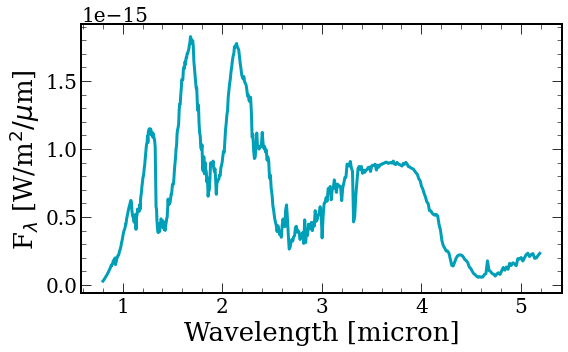

In [24]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(wavelength, model, linewidth = 3)
ax.set_xlabel("Wavelength [micron]")
ax.set_ylabel(r"F$_{\lambda}$ [W/m$^{2}/\mu$m]")

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


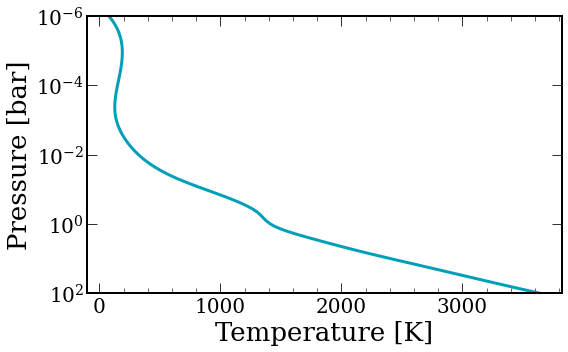

In [23]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(temperature, pressure, linewidth = 3)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_yscale('log')

We can do the same for the transmission spectrum models:

For every model we need to supply two of the `mass`, `R_pl` or `log_g` in order to compute the surface gravity of the object.
All of the models can combine various cloud implementations, see the [cloud tutorial](../clouds.html) for more information.
All of the transmission models can use either (dis)equilibrium or free chemistry, or some combination of the two.
For the specific details of the required parameters, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/models/index.html).

- `isothermal_transmission`: This model assumes a constant temperature throughout the atmosphere. Clouds can be patchy or have complete coverage.
- `guillot_transmission`: This model uses the Guillot 2010 profile,.
- `guillot_patchy_transmission`: Also based on Guillot 2010, this model also allows for the use of patchy clouds.
- `madhu_seager_patchy_transmission`: This model implements the Madhushudan and Seager (2009) temperature profile, and also allows for patchy clouds.

In [25]:
from petitRADTRANS.retrieval.models import isothermal_transmission,\
                                           guillot_transmission,\
                                           guillot_patchy_transmission,\
                                           madhu_seager_patchy_transmission

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For our transmission example, we'll use a WASP39 b type planet.

In [38]:
parameters = {}

parameters['Rstar'] = Parameter( 'Rstar',False, value = 0.9324 * nc.r_sun)
parameters['D_pl'] = Parameter('D_pl', False, value = 230.0*nc.pc)

parameters['R_pl'] = Parameter('R_pl', False, value =  1.3*nc.r_jup_mean) # cm
parameters['log_g'] = Parameter('log_g', False, value =  2.75) # from my fit

parameters['T_int'] = Parameter('T_int', False, value = 750)
parameters['T_equ'] = Parameter('T_equ', False, value = 600)
parameters['log_kappa_IR'] = Parameter('log_kappa_IR', False, value = -1.0)
parameters['gamma'] = Parameter('gamma', False, value = 1.0)

parameters['kappa_0'] = Parameter('kappa_0', False, value = 0.0)
parameters['gamma_scat'] = Parameter('gamma_scat', False, value = -1.9)
parameters['log_Pcloud'] = Parameter('log_Pcloud', False, value = 0)

parameters['Fe/H'] = Parameter('Fe/H', False, value = 1.0)
parameters['C/O'] = Parameter('C/O', False, value = 0.1)

parameters['patchiness'] = Parameter('patchiness',False,value = 0.7)

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
line_species = ['H2O_Exomol_R_300', 
                'CO_all_iso_HITEMP_R_300', 
                'CH4_R_300', 
                'CO2_R_300', 
                'HCN_R_300', 
                'FeH_R_300', 
                'H2S_R_300', 
                'NH3_R_300', 
                'PH3_R_300', 
                'Na_allard_R_300', 
                'K_allard_R_300', 
                'TiO_all_Exomol_R_300', 
                'VO_R_300',
                'SiO_R_300']

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []

atmosphere = Radtrans(line_species = line_species,
                      rayleigh_species= rayleigh_species,
                      continuum_opacities = continuum_opacities,
                      cloud_species = cloud_species,
                      mode='c-k',
                      do_scat_emis=False,
                      wlen_bords_micron = [0.8,5.2])
pressures = np.logspace(-6,2,100)
atmosphere.setup_opa_structure(pressures)

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:121: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  FutureWarning)


  Read line opacities of H2O_Exomol_R_300...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_300...
 Done.
  Read line opacities of CH4_R_300...
 Done.
  Read line opacities of CO2_R_300...
 Done.
  Read line opacities of HCN_R_300...
 Done.
  Read line opacities of FeH_R_300...
 Done.
  Read line opacities of H2S_R_300...
 Done.
  Read line opacities of NH3_R_300...
 Done.
  Read line opacities of PH3_R_300...
 Done.
  Read line opacities of Na_allard_R_300...
 Done.
  Read line opacities of K_allard_R_300...
 Done.
  Read line opacities of TiO_all_Exomol_R_300...
 Done.
  Read line opacities of VO_R_300...
 Done.
  Read line opacities of SiO_R_300...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [40]:
wavelength, model = guillot_patchy_transmission(atmosphere, parameters, AMR = False, PT_plot_mode = False)
pressure,temperature = guillot_patchy_transmission(atmosphere, parameters, AMR = False, PT_plot_mode = True)

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'F$_{p}$/F$_{\\rm star}$ [ppm]')

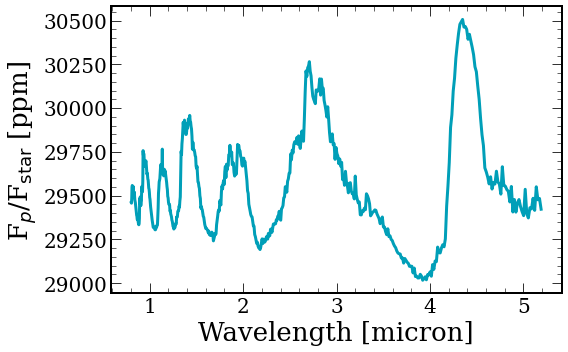

In [41]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(wavelength, model*1e6, linewidth = 3)
ax.set_xlabel("Wavelength [micron]")
ax.set_ylabel(r"F$_{p}$/F$_{\rm star}$ [ppm]")

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


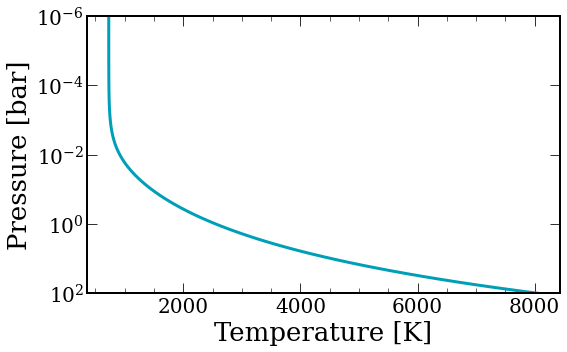

In [42]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(temperature, pressure, linewidth = 3)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_yscale('log')